In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline


# Spruce wood
# Young modulus E [MPa], specific weight gamma [N/m3]
# X = [E, gamma]
mu_X = np.array([11e3, 6e3])

sig_x1 = 2e3
sig_x2 = 1e3
rho = 0.8
C_x = np.array([[sig_x1**2, rho*sig_x1*sig_x2],
                [rho*sig_x1*sig_x2, sig_x2**2]])

samples_X = np.random.multivariate_normal(mu_X, C_x, 10000)

print('Generated samples of E and gamma:')
print(samples_X)
print('Average E and gamma:')
print(np.average(samples_X[:,0]), np.average(samples_X[:,1]))

Generated samples of E and gamma:
[[ 9502.12874927  7117.40353423]
 [10601.79588046  5402.26069409]
 [ 9733.97560086  5843.1078186 ]
 ...
 [14005.03840113  6688.13683842]
 [12724.50667499  6378.01673951]
 [13336.02294423  6649.35898583]]
Average E and gamma:
11015.648614127667 6009.845531135723


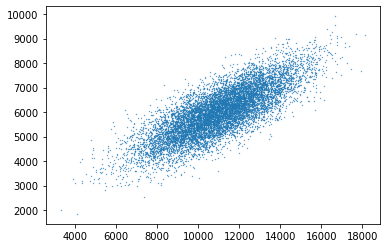

In [3]:
#plt.gca().set_aspect('equal', adjustable='box') # Equal scale on both axes
scatter_X = plt.scatter(samples_X[:,0], samples_X[:,1], s=0.1)

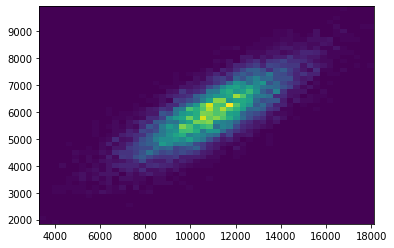

In [4]:
histogram_X = plt.hist2d(samples_X[:,0], samples_X[:,1], 50)

In [5]:
# Dimensions of beam
b = 0.005
h = 0.002
l = 1.0
A = b * h
I = 1 / 12 * b * h**3

# Deflection [m] of simply supported beam
def g(x):
    E = x[0] * 1e6 # Pa
    gamma = x[1] # N/m3
    q = A * gamma # N/m
    w = 5/384 * q * l**4 / E / I # m
    return w

print('Deflection for mean E and mean gamma:')
print(g(mu_X))
print('Deflection for average E and average gamma:')
print(g([np.average(samples_X[:,0]), np.average(samples_X[:,1])]))

Deflection for mean E and mean gamma:
0.021306818181818187
Deflection for average E and average gamma:
0.021311463290405612


In [6]:
samples_Y = np.array([g(x) for x in samples_X])
print('Samples of deflection:')
print(samples_Y)
print('Mean deflection:')
print(np.average(samples_Y))

Samples of deflection:
[0.02925908 0.01990472 0.02344843 ... 0.01865438 0.01957964 0.01947662]
Mean deflection:
0.021522631552126272


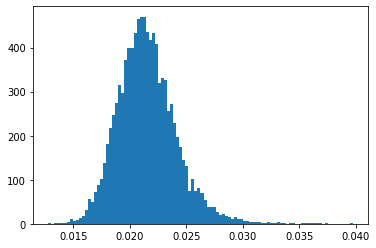

In [7]:
histogram_Y = plt.hist(samples_Y, bins=100)

In [8]:
w_limit = 0.025

# Conditional PDF
# Not PDF, does not integrate to 1.
def f_conditional(x):
    if g(x) > w_limit:
        return sp.stats.multivariate_normal.pdf(x, mu_X, C_x)
    else:
        return 0

# Initial sample    
x0 = [6e3, 5e3]
print(f_conditional(x0))
print(f_conditional(mu_X))


1.4530543174997753e-09
0


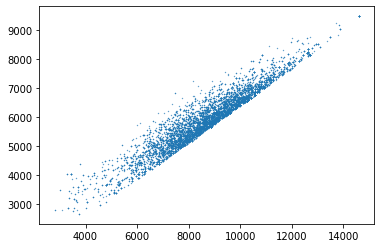

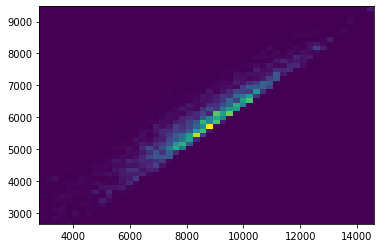

In [9]:
# Metropolis-Hastings
# -------------------

def get_candidate(x_current):
    # Trial (jumping) distribution
    mean = x_current
    c = 0.5
    cov = np.array([[(c*sig_x1)**2, 0.0],[0.0, (c*sig_x2)**2]])
    x_candidate = np.random.multivariate_normal(mean, cov, 1)[0]
    return x_candidate

def get_new_sample(x_candidate, x_current, f):
    f_can = f(x_candidate)
    f_cur = f(x_current)
    if f_can / f_cur > np.random.random():
        return x_candidate
    else:
        return x_current

samples_Xr = [x0]    
for i in range(10000):
    x_current = samples_Xr[-1]
    x_candidate = get_candidate(x_current)
    x_new = get_new_sample(x_candidate, x_current, f_conditional)
    samples_Xr.append(x_new)

samples_Xr = np.array(samples_Xr)

scatter_Xr = plt.scatter(samples_Xr[:,0], samples_Xr[:,1], s=0.1)
plt.show()
histgram_Xr = plt.hist2d(samples_Xr[:,0], samples_Xr[:,1], 50)
plt.show()

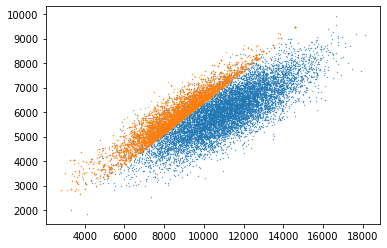

In [10]:
plt.scatter(samples_X[:,0], samples_X[:,1], s=0.1)
plt.scatter(samples_Xr[:,0], samples_Xr[:,1], s=0.1)

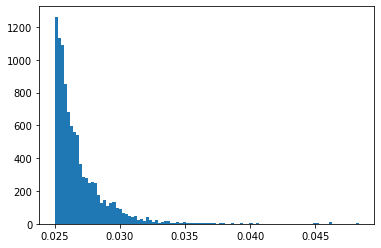

In [11]:
samples_Yr = np.array([g(x) for x in samples_Xr])
histogram_Yr = plt.hist(samples_Yr, 100)

In [12]:
num_1 = sum(w > w_limit for w in samples_Y)
p_w1 = num_1 / len(samples_Y)
print('p(w>{}):'.format(w_limit))
print('{} ({}/{})'.format(p_w1,num_1,len(samples_Y)))
print()

w_failure = 0.03
num_2 = sum(w > w_failure for w in samples_Yr)
p_w2_w1 = num_2 / len(samples_Yr)
print('p(w>{}|w>{}):'.format(w_failure, w_limit))
print('{} ({}/{})'.format(p_w2_w1,num_2,len(samples_Yr)))
print()

print('p(w>{}) = p(w>{}|w>{}) * p(w>{}):'.format(w_failure, w_failure, w_limit, w_limit))
print(p_w2_w1 * p_w1)


p(w>0.025):
0.0861 (861/10000)

p(w>0.03|w>0.025):
0.064993500649935 (650/10001)

p(w>0.03) = p(w>0.03|w>0.025) * p(w>0.025):
0.005595940405959404


In [13]:
num_2_mc = sum(w > w_failure for w in samples_Y)
p_w2_mc = num_2_mc / len(samples_Y)
print('Brute force MC p(w>{}):'.format(w_failure))
print('{} ({}/{})'.format(p_w2_mc, num_2_mc, len(samples_Y)))
print(p_w2_mc)

Brute force MC p(w>0.03):
0.0055 (55/10000)
0.0055
